# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np

customer_solvency = pd.read_csv('/datasets/data.csv')

### Выведем общую информацию о датафрейме и посмотрим на типы данных

In [2]:
customer_solvency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Проверим наличие дубликатов

In [3]:
customer_solvency.duplicated().sum()

54

### ... и пропусков

In [4]:
customer_solvency.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

### Посмотрим на первые и последние 5 записей

In [5]:
customer_solvency.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [6]:
customer_solvency.tail()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля
21524,2,-1984.507589,40,среднее,1,женат / замужем,0,F,сотрудник,0,82047.418899,на покупку автомобиля


### Пробежимся по всем колонкам и найдем странности

#### Количество детей

In [7]:
customer_solvency.sort_values('children')['children'].value_counts().sort_index()

-1        47
 0     14149
 1      4818
 2      2055
 3       330
 4        41
 5         9
 20       76
Name: children, dtype: int64

#### Общий трудовой стаж в днях. Отрицательные значения!

In [8]:
customer_solvency[customer_solvency['days_employed'] < 0]['days_employed'].count()

15906

#### Положительные значения слишком большие для количества дней, даже для людей приклонного возраста

In [9]:
customer_solvency[customer_solvency['days_employed'] > 0].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
18,0,400281.136913,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.777243,на покупку подержанного автомобиля
24,1,338551.952911,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547.235997,операции с коммерческой недвижимостью
25,0,363548.489348,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.757732,покупка недвижимости
30,1,335581.668515,62,среднее,1,женат / замужем,0,F,пенсионер,0,171456.067993,операции с коммерческой недвижимостью


#### Возраст

In [10]:
customer_solvency.sort_values('dob_years')['dob_years'].value_counts().sort_index()

0     101
19     14
20     51
21    111
22    183
23    254
24    264
25    357
26    408
27    493
28    503
29    545
30    540
31    560
32    510
33    581
34    603
35    617
36    555
37    537
38    598
39    573
40    609
41    607
42    597
43    513
44    547
45    497
46    475
47    480
48    538
49    508
50    514
51    448
52    484
53    459
54    479
55    443
56    487
57    460
58    461
59    444
60    377
61    355
62    352
63    269
64    265
65    194
66    183
67    167
68     99
69     85
70     65
71     58
72     33
73      8
74      6
75      1
Name: dob_years, dtype: int64

#### Образование

In [11]:
customer_solvency.sort_values('education')['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

#### Семейное положение

In [12]:
customer_solvency['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

#### Пол

In [13]:
customer_solvency['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

#### Тип занятости

In [14]:
customer_solvency['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

#### Доход

In [15]:
# Проверим есть ли люди с нулевым уровнем дохода
customer_solvency[customer_solvency['total_income'] == 0]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


In [16]:
# А что насчет пропусков?
null_rows = customer_solvency[customer_solvency['total_income'].isnull()]

In [17]:
null_rows.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


Попытаемся проанализировать распределение по другим признакам, *по которым нам не нужно предварительно делать категоризацию*,
чтобы выделить срез для подсчета медианы для заполнения пропусков.

In [18]:
null_rows['children'].value_counts()

 0     1439
 1      475
 2      204
 3       36
 20       9
 4        7
-1        3
 5        1
Name: children, dtype: int64

🎗*Выделяются клиенты без детей*

In [19]:
null_rows['gender'].value_counts()

F    1484
M     690
Name: gender, dtype: int64

🎗Выделяются клиенты женского пола

In [20]:
null_rows['debt'].value_counts()

0    2004
1     170
Name: debt, dtype: int64

🎗Выделяются клиенты, не имевшие задолжностей

#### Цель получения кредита

In [21]:
customer_solvency['purpose'].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
операции с жильем                         653
покупка жилья для сдачи                   653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

### Вывод

* Наш датасет состоит из _21 525_ записей;

* Из них 54 дубликата – не много, однако это сырые данные и количество дубликатов может измениться после базовой предобработки;

* Одинаковое количество пропусков в столбцах `days_employed` и `total_income` – _2 174_. Связь между этими столбцами понятна: невозможно рассчитать общий доход не имея информации о стаже. Не все компании и люди работают по ТК РФ 😔Так как столбец `total_income` нам нужен для ответа на вопрос _"Есть ли зависимость между уровнем дохода и возвратом кредита в срок?"_ , то от этих записей пользы нет. Тем более такая категория клиентов – **high risk** для банка.

* 🆕Попробуем восстановить пропуски заменив `NaN` на медианные значения по срезу клиентов, выделенному при анализе датасета, чтобы сильно не сдвигать распределение: _Женщины без детей и не имевшие задолжностей по кредитам._

* Столбец `children`:
    * Для 47 записей количество детей равно `-1` – т.к. у нас нет возможности связаться с коллегами, которые сделали нам выгрузку датасета, и причину появления таких значений установить сложно (например, клиенты банка просто не захотели делиться такой информацией), будем считать их нерепрезентативными и удалим эти записи. Их всего 47, и они не должны коренным образом повлиять на анализ;
    * 76 человек имеет по 20 детей 😲Выглядит как ошибка в данных, у нас же не 🐰Снова, мы могли бы предположить, что корретное значение – это `2`, а `0` появился при неправильном заполнении данных. Но это как гадать на кофейной гуще – можно, но не факт, что сбудется. Удаляем;

* Столбец `days_employed` имеет тип `float64` и содержит отрицательные значения. Всего таких записей _15 906_ , т.е. **~73%** от общего числа!
    * Будем работать с днями, поэтому приведем тип столбца к `int64`;
    * Положительные значения из датасета выглядят странными. Например, 343937.404131 / 365 дней = 942 лет стажа❗️Хорошо, что в решении бизнес задачи этот столбец нам не пригодится. В противном случае пришлось бы идти к коллегам рассказывать об ошибке в выгрузке данных и выяснять причину появления ошибок 💡
    * А вот отрицательные значения (потеряно дней жизни? 😃) сделаем абсолютными, т.к. эти данные выглядят правдоподобнее. Даже свою функцию писать не придется – применим стандартную `abs`. Сделаем это для тренировки и улучшения читабельности данных 🤓

* Столбец `dob_years` – для 101 человека возраст неизвестен. Для ответа на вопросы бизнеса этот стоблец не используется. Возьмем на заметку и оставим как есть ❗️

* В столбце `education` встречаются категории в разном регистре – нужно будет привести к единому виду, например, все в lowercase. И еще раз проверить на дубликаты. Предварительно убедимся в том, что `education_id` соотносится с нужным типом образования;

* В столбце `family_status` только одна категория `Не женат / не замужем` выбивается из общей семантики именования – начинается с заглавной буквы;

* У одного клиента неизвестен пол – для анализа этот столбец мы не используем, поэтому пока оставим эту запись;

* Столбец `purpose` содержит разные формулировки одних и тех же целей – применим лемматизацию.

### Шаг 2. Предобработка данных

### Обработка пропусков

При первичном анализе пропусков мы увидели, что среди них выделяются *женщины без детей и имевшие задолжность по кредитам*. Проверим сколько записей без пропусков подпадает под это условие, чтобы посчитать медиану и заполнить пропуски.

In [22]:
notnull_rows = customer_solvency[
    (customer_solvency['total_income'].notnull()) & 
    (customer_solvency['gender'] == 'F') & 
    (customer_solvency['children'] == 0) &
    (customer_solvency['debt'] == 0)
]

In [23]:
notnull_rows['total_income'].count()

8041

Вычислим медиану для количества дней стажа и дохода соответственно.

In [24]:
median_days_employed = notnull_rows['days_employed'].median()

In [25]:
median_days_employed

-948.3419275862352

In [26]:
median_total_income = notnull_rows['total_income'].median()

In [27]:
median_total_income

134143.86895877813

In [28]:
# Теперь восстановим пропуски при помощи вычисленных значений
customer_solvency.loc[customer_solvency['days_employed'].isnull(), 'days_employed'] = median_days_employed

In [29]:
customer_solvency.loc[customer_solvency['total_income'].isnull(), 'total_income'] = median_total_income

In [30]:
# Избавляемся от записей, в которых есть ошибочные данные
customer_solvency = customer_solvency[(customer_solvency['children'] >= 0) & (customer_solvency['children'] <= 5)]
customer_solvency.sort_values('children')['children'].value_counts().sort_index()

0    14149
1     4818
2     2055
3      330
4       41
5        9
Name: children, dtype: int64

### Вывод

In [31]:
customer_solvency.shape[0]

21402

Мы избавились от пропусков, оставив только необходимые для будущего анализа данные.

### Замена типа данных

In [32]:
customer_solvency['days_employed'] = customer_solvency['days_employed'].astype('int').apply(abs)

In [33]:
customer_solvency.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


### Вывод

Преобразовали количество дней стажа в целочисленный тип при помощи метода `astype`, т.к. `to_numeric` служит для конвертации строк и приводит их к числам с плавающей точкой. Дополнительно столбец избавился от отрицательных значений.

### Обработка дубликатов

In [34]:
# Приведем значения в столбце Уровень образования клиента к единому регистру
customer_solvency['education'] = customer_solvency['education'].str.lower()

In [35]:
customer_solvency.sort_values('education')['education'].value_counts()

среднее                15136
высшее                  5237
неоконченное высшее      741
начальное                282
ученая степень             6
Name: education, dtype: int64

In [36]:
customer_solvency.duplicated().sum()

71

### Вывод

После нормализации значений колонки `education` необходимость в удалении дубликатов при помощи метода `drop_duplicates()` отпала. Их количество равно 0.

### Лемматизация

In [37]:
from collections import Counter

# Воспользуемся библиотекой Mystem от Яндекса
from pymystem3 import Mystem
m = Mystem()

# Попробуем найти самые частовстречаемые слова в леммах и на основе результата определить категории целей кредита
purposes = []

for p in customer_solvency['purpose']:
    lemma = m.lemmatize(p)
    purposes += filter(lambda l: l not in [' ', '\n', 'с', 'со', 'на'], lemma)

print(Counter(purposes))

Counter({'недвижимость': 6330, 'покупка': 5880, 'жилье': 4450, 'автомобиль': 4288, 'образование': 3997, 'операция': 2593, 'свадьба': 2337, 'свой': 2224, 'строительство': 1870, 'высокий': 1368, 'получение': 1311, 'коммерческий': 1307, 'для': 1291, 'жилой': 1225, 'сделка': 939, 'заниматься': 908, 'дополнительный': 902, 'проведение': 772, 'сыграть': 769, 'сдача': 651, 'семья': 640, 'собственный': 628, 'ремонт': 609, 'подержанный': 484, 'подержать': 472, 'приобретение': 460, 'профильный': 432})


In [38]:
# В приведенном выше множестве мы вимим общие слова типа "покупка", "операция", "строительство" и пр.
# Если их откинуть, то наиболее частовстречаемыми категориями будут:
purpose_category = [
    'свадьба',
    'недвижимость',
    'жилье',
    'автомобиль',
    'образование'
]

In [39]:
# Опишем функцию, которую будем вызывать при добавлении нового стобца
def categorize_purpose(text):
    """
    Функция возвращает категорию цели креди на основе лемматизированного текста.
    
    P.S. Поиск вхождения категории в лемму можно реализовать более оптимально через пересечение множеств.
    Тем не менее имплементация с вложенными циклами или list comprehensions более явная.
    """
    
    lemmas = m.lemmatize(text)
    for lemma in lemmas:
        for category in purpose_category:
            if category in lemma:
                return category
        

# "Протестируем" функцию
categorize_purpose('Ах эта свадьба, свадьба, свадьба пела и плясала...')

'свадьба'

In [40]:
# Наконец, добавим новый столбец с категориями целей кредита
customer_solvency['purpose_category'] = customer_solvency['purpose'].apply(categorize_purpose)

In [41]:
customer_solvency.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,жилье
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,жилье
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,свадьба


### Вывод

Из большого числа вариаций получили всего пять категорий целей кредита – читать и анализировать такие данные намного проще.

### Категоризация данных

Для ответа на нижеперечисленные вопросы нам необходимо сегментировать пользователей. Четыре вопроса – четыре раза выполним категоризацию.

> Есть ли зависимость между наличием детей и возвратом кредита в срок?

Распределим клиентов по наличию детей:

* 0 – бездетная
* 1 – однодетная
* 2 – малодетная
* 3+ – многодетная

In [42]:
def categorize_children(count):
    categories = {
        0: 'бездетная',
        1: 'однодетная',
        2: 'малодетная'
    }

    return categories.get(count, 'многодетная')

In [43]:
customer_solvency['children_category'] = customer_solvency['children'].apply(categorize_children)

In [44]:
customer_solvency.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category,children_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,жилье,однодетная
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,автомобиль,однодетная
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,жилье,бездетная
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,образование,многодетная
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,свадьба,бездетная


> Есть ли зависимость между семейным положением и возвратом кредита в срок?

По семейному положению – вопрос интересный. Всего у нас пять категорий (см. `Out[12]`), но давайте сузим запрос и возьмем за основу `family_status_id` до следующих категории:

* "в браке" – женат / замужем, гражданский брак
* "не в браке" – не женат / не замужем, в разводе, вдовец / вдова

In [45]:
def categorize_family_status(value):
    if value == 'женат / замужем':
        return 'в браке'
    
    return 'не в браке'

In [46]:
customer_solvency['family_status_category'] = customer_solvency['family_status'].apply(categorize_family_status)

In [47]:
customer_solvency.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category,children_category,family_status_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,жилье,однодетная,в браке
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,автомобиль,однодетная,в браке
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,жилье,бездетная,в браке
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,образование,многодетная,в браке
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,свадьба,бездетная,не в браке


> Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Уровень дохода клиента лучше рассматривать в рамках определенного города или региона, так как уровень жизни и зарплаты могут сильно отличаться, например, в Москве и Брянске. Но у нас подобных данных в датасете нет.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e76f66cc0>]],
      dtype=object)

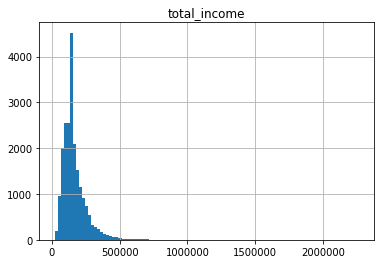

In [59]:
customer_solvency.hist(column='total_income', bins=100)

Т.к. мы восстановили пропуски, то минимальное значение признака `total_income` равно `0`. Найдем таже медиану и максимальное значение.

In [49]:
timedian = customer_solvency['total_income'].median()

In [50]:
timedian

135454.3051726866

In [51]:
customer_solvency['total_income'].max()

2265604.028722744

In [52]:
def categorize_total_income(value):
    if value < 50_000:
        return 'низкий'
    elif value <= timedian:
        return 'средний'
    elif value < 350_000:
        return 'выше среднего'
    else:
        return 'высокий'

In [53]:
customer_solvency['total_income_category'] = customer_solvency['total_income'].apply(categorize_total_income)

In [54]:
customer_solvency.tail()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category,children_category,family_status_category,total_income_category
21520,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,жилье,однодетная,не в браке,выше среднего
21521,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем,автомобиль,бездетная,в браке,выше среднего
21522,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,недвижимость,однодетная,не в браке,средний
21523,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,автомобиль,многодетная,в браке,выше среднего
21524,2,1984,40,среднее,1,женат / замужем,0,F,сотрудник,0,82047.418899,на покупку автомобиля,автомобиль,малодетная,в браке,средний


> Как разные цели кредита влияют на его возврат в срок?

Цели кредита мы уже категоризовали выше на этапе лемматизации:

* свадьба
* недвижимость
* жилье
* автомобиль
* образование

### Вывод

Мы категоризовали данные. Теперь, группируя данные по нашим категориям, мы сможем ответить на вопросы ниже.

### Шаг 3. Ответьте на вопросы

#### 1. Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [55]:
pd.pivot_table(customer_solvency, index='children_category', values='debt')

,debt
children_category,
бездетная,0.075129
малодетная,0.094404
многодетная,0.081579
однодетная,0.092154


#### Вывод

* Прямой зависимости между наличием детей и возвратом кредита в срок нет: до `9.4%` клиентов имели задолжности по кредитам, независимо от того были у них дети или нет.
* Бездетные семьи чаще выплачивают кредит (ожидаемо): `~7.5%`.
* Что интересно, многодетные семьи реже остаются в должниках `~8.2%`, чем семьи с одним ребенком `~9.2%` или двумя `~9.4%`.

#### 2. Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [56]:
pd.pivot_table(customer_solvency, index='family_status_category', values='debt')

,debt
family_status_category,
в браке,0.075354
не в браке,0.088462


#### Вывод

Клиенты, состоящие в браке, на `1.3%` реже остаются в должниках.

#### 3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [57]:
pd.pivot_table(customer_solvency, index='total_income_category', values='debt')

,debt
total_income_category,
высокий,0.064252
выше среднего,0.082377
низкий,0.061995
средний,0.081607


#### Вывод

* ✔️Как и ожидалось, люди с высоким уровнем дохода реже остаются в должниках: `~6.4%`.
* ✔️Заметной разницы между клиентами со средним и выше среднего уровнями дохода нет: `~8.1%` против `~8.2%` должников.
* 😲Люди с низким уровнем дохода реже остальных имеют задолжности по кредитам: `~6.2%`.

_Таким образом, мы не можем сказать, что чем выше доход клиента, тем ниже уровень риска при выдаче кредита. Но можем выделить 2 категории: люди с низким и высоким дохода 🤔_

#### 4. Как разные цели кредита влияют на его возврат в срок?

In [58]:
pd.pivot_table(customer_solvency, index='purpose_category', values='debt')

,debt
purpose_category,
автомобиль,0.093284
жилье,0.069213
недвижимость,0.074566
образование,0.092319
свадьба,0.078306


#### Вывод

Посчитав % задолжностей по категориям, можно сделать вывод, что автомобиль `9.3%` и образование `9.2%` не на первом месте в списке приоритетов на выплаты у клиентов, в отличие от жилья `~6.9%`, недвижимости `7.5%` и свадьбы `7.8%`.

### Шаг 4. Общий вывод

Исходя из предыдущих выводов, мы можем сделать следующую рекомедацию бизнесу по выдаче кредита: безопаснее всего выдавать кредиты на покупку жилья, недвижимости или свадьбу – по ним меньшее количество задолжностей.

Для более детального ответа необходимо рассмотреть следующие факты в совокупности:

* Клиенты без детей 😦
* Семейные ☝️
* С низким или высоким уровнями дохода 💵
* Цель кредита – жилье или недвижимость 🎯

Возможно это идеальный портрет клиента.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.

## Полезные ссылки

* [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF)